In [22]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.1/12.8 MB 544.7 kB/s eta 0:00:24
     ---------------------------------------- 0.1/12.8 MB 1.1 MB/s eta 0:00:12
      --------------------------------------- 0.2/12.8 MB 1.2 MB/s eta 0:00:11
     - -------------------------------------- 0.3/12.8 MB 1.4 MB/s eta 0:00:09
     - -------------------------------------- 0.4/12.8 MB 1.7 MB/s eta 0:00:08
     - -------------------------------------- 0.6/12.8 MB 1.8 MB/s eta 0:00:07
     -- ------------------------------------- 0.7/12.8 MB 2.0 MB/s eta 0:00:06
     -- ------------------------------------- 0.9/12.8 MB 2.2 MB/s eta 0:00:06
     -- ------------------------------------- 0.9/12.8 MB 2.0 MB/s eta 0:00:06
     --- ------------------------------------ 1.0/12.8 MB 2.1 MB/s eta 0:00:06
     --- ------------------------------------ 1.2/12.8 MB 2.2 MB/


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from pathlib import Path
import pandas as pd
import spacy
# Add project root to Python path (go up one level from notebooks/)
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
from main import load_config
import numpy as np
from collections import Counter
import re

In [24]:
config = load_config("configs/config.yaml")
model_name_destileldBert = 'distilbert-base-uncased'
model_name_bert = 'bert-base-uncased'


Loaded config from c:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Final Exam\AVDNLP_final_project\AVDNLP_final_project\configs\config.yaml


In [25]:
# ...existing code...
from pathlib import Path
import os

def find_project_root(start: Path = None, markers=(".git", "pyproject.toml", "setup.py")) -> Path:
    start = Path(start or Path.cwd()).resolve()
    for p in [start] + list(start.parents):
        if any((p / m).exists() for m in markers):
            return p
    return Path.cwd()

# Prefer explicit env var for cloud runs; otherwise try __file__ then cwd then repo-root
project_root = None
if "PROJECT_ROOT" in os.environ:
    project_root = Path(os.environ["PROJECT_ROOT"]).resolve()
else:
    try:
        # works in scripts, not in notebooks
        project_root = Path(__file__).parent.resolve()
    except NameError:
        # notebook / interactive fallback: try repo root then cwd
        project_root = find_project_root()

# build paths relative to project_root
notebooks_dir = project_root / "notebooks"
mis_dir = notebooks_dir / "misclassifications"

bert_path = mis_dir / "misclassifications_Stanford_bert_partial_finetune.csv"
bert_lora_path = mis_dir / "misclassifications_Stanford_bert_lora_r8.csv"
distilled_bert_path = mis_dir / "misclassifications_Stanford_distilbert_partial_finetune.csv"
distilled_bert_lora_path = mis_dir / "misclassifications_Stanford_distilbert_lora_r8.csv"

print("Using project_root:", mis_dir)

Using project_root: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Final Exam\AVDNLP_final_project\AVDNLP_final_project\notebooks\misclassifications


In [26]:
# ...existing code...
from pathlib import Path

def find_file(name, start=project_root):
    start = Path(start or Path.cwd()).resolve()
    return list(start.rglob(name))

print("project_root:", project_root)
print("mis_dir:", mis_dir)
print("expected bert_path:", bert_path)
print("bert_path.exists():", bert_path.exists())

if not bert_path.exists():
    print("Searching repo for misclassifications_Stanford_bert_partial_finetune.csv ...")
    found = find_file("misclassifications_Stanford_bert_partial_finetune.csv", project_root)
    if not found:
        raise FileNotFoundError(f"Could not locate misclassifications_Stanford_bert_partial_finetune.csv under {project_root}")
    bert_path = found[0]
    print("Found bert_path at:", bert_path)

# helper to load or search
def load_or_search(p: Path):
    if isinstance(p, str):
        p = Path(p)
    if p.exists():
        return pd.read_csv(p)
    found = find_file(p.name, project_root)
    if not found:
        raise FileNotFoundError(f"Could not locate {p.name} under {project_root}")
    print(f"Loading {p.name} from {found[0]}")
    return pd.read_csv(found[0])

df_bert = load_or_search(bert_path)
df_bert_lora = load_or_search(bert_lora_path)
df_distilled_bert = load_or_search(distilled_bert_path)
df_distilled_bert_lora = load_or_search(distilled_bert_lora_path)

print("Loaded dataframes:", { 'bert': len(df_bert), 'bert_lora': len(df_bert_lora),
                             'distilled': len(df_distilled_bert), 'distilled_lora': len(df_distilled_bert_lora) })
# ...existing code...

project_root: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Final Exam\AVDNLP_final_project\AVDNLP_final_project
mis_dir: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Final Exam\AVDNLP_final_project\AVDNLP_final_project\notebooks\misclassifications
expected bert_path: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Final Exam\AVDNLP_final_project\AVDNLP_final_project\notebooks\misclassifications\misclassifications_Stanford_bert_partial_finetune.csv
bert_path.exists(): False
Searching repo for misclassifications_Stanford_bert_partial_finetune.csv ...
Found bert_path at: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Final Exam\AVDNLP_final_project\AVDNLP_final_project\misclassifications\misclassifications_Stanford_bert_partial_finetune.csv
Loading misclassifications_Stanford_bert_lora_r8.csv from C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Fina

In [27]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

models = {
    "bert_lora": df_bert_lora,
    "bert_partial": df_bert,
    "distil_lora": df_distilled_bert_lora,
    "distil_partial": df_distilled_bert
}

# Standardize text column name
for name, df in models.items():
    if "text" not in df.columns:
        df.rename(columns={df.columns[0]: "text"}, inplace=True)


# -------------------------------------------------------------------
# HELPERS
# -------------------------------------------------------------------

def extract_keywords(texts, top_k=20):
    words = []
    for t in texts:
        tokens = re.findall(r"[A-Za-z]+", str(t).lower())
        words.extend([w for w in tokens if w not in stopwords and len(w) > 2])
    
    counts = Counter(words)
    return counts.most_common(top_k)


def compute_label_distribution(df):
    return df["true_label"].value_counts(normalize=True)


def overlap_rate(a, b):
    """Measure textual overlap between two sets of edge cases."""
    s1 = set(a["text"].tolist())
    s2 = set(b["text"].tolist())
    return len(s1 & s2) / len(s1 | s2)

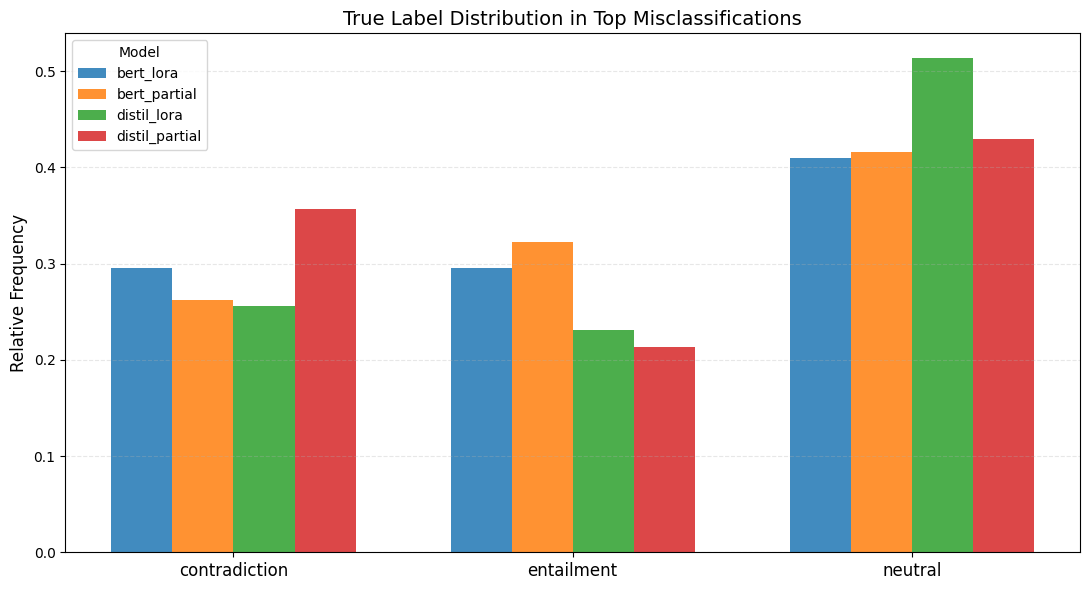

In [28]:
# Collect all label names
label_set = sorted(set().union(*[df["true_label"].unique() for df in models.values()]))

# Build matrix: rows = labels, columns = models
dist_matrix = pd.DataFrame(
    {
        name: df["true_label"].value_counts(normalize=True)
                           .reindex(label_set, fill_value=0)
        for name, df in models.items()
    }
)

labels = label_set
model_names = list(models.keys())

n_labels = len(labels)
n_models = len(model_names)

x = np.arange(n_labels)
width = 0.18  # bar width

plt.figure(figsize=(11, 6))

for i, name in enumerate(model_names):
    plt.bar(
        x + (i - n_models/2) * width + width/2,
        dist_matrix[name],
        width,
        label=name,
        alpha=0.85
    )

plt.xticks(x, labels, fontsize=12)
plt.ylabel("Relative Frequency", fontsize=12)
plt.title("True Label Distribution in Top Misclassifications", fontsize=14)
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

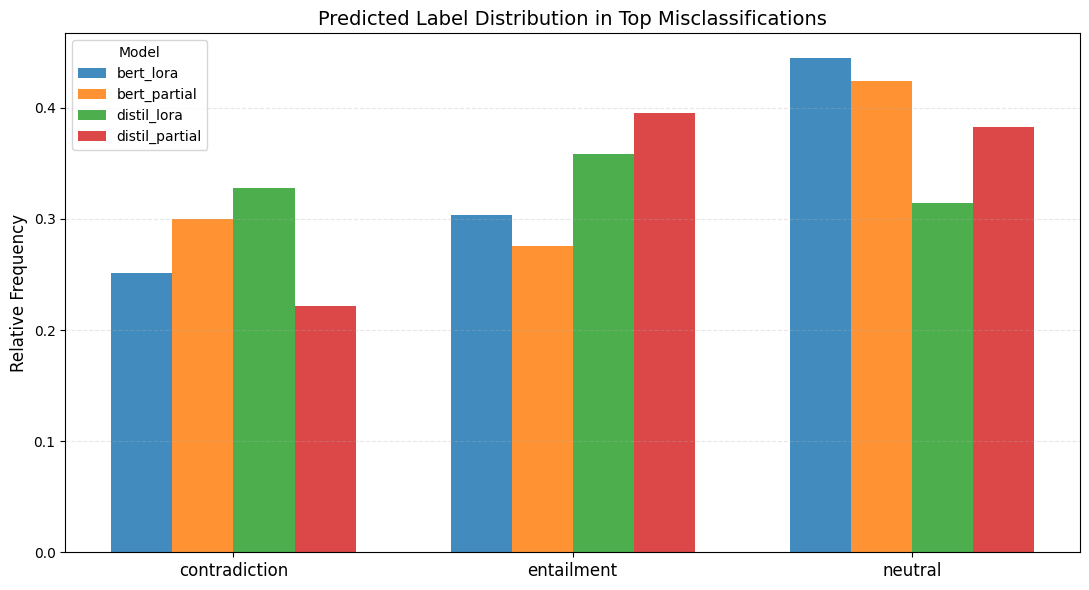

In [29]:
# Collect all predicted label names
pred_label_set = sorted(set().union(*[df["predicted_label"].unique() for df in models.values()]))

# Build matrix: rows = labels, columns = models
pred_dist_matrix = pd.DataFrame(
    {
        name: df["predicted_label"].value_counts(normalize=True)
                              .reindex(pred_label_set, fill_value=0)
        for name, df in models.items()
    }
)

pred_labels = pred_label_set
model_names = list(models.keys())

n_labels = len(pred_labels)
n_models = len(model_names)

x = np.arange(n_labels)
width = 0.18

plt.figure(figsize=(11, 6))

for i, name in enumerate(model_names):
    plt.bar(
        x + (i - n_models/2) * width + width/2,
        pred_dist_matrix[name],
        width,
        label=name,
        alpha=0.85
    )

plt.xticks(x, pred_labels, fontsize=12)
plt.ylabel("Relative Frequency", fontsize=12)
plt.title("Predicted Label Distribution in Top Misclassifications", fontsize=14)
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# -------------------------------------------------------------------
# 3) KEYWORD ANALYSIS FOR EACH MODEL
# -------------------------------------------------------------------
keyword_summary = {}

for name, df in models.items():
    top_keywords = extract_keywords(df["text"])
    keyword_summary[name] = top_keywords
    print(f"\n===== Top Keywords for {name} =====")
    for w, c in top_keywords[:20]:
        print(f"{w}: {c}")


===== Top Keywords for bert_lora =====
man: 7728
woman: 3879
people: 3268
wearing: 2338
young: 1820
shirt: 1750
men: 1705
white: 1702
girl: 1659
black: 1589
boy: 1577
dog: 1505
playing: 1496
blue: 1383
sitting: 1343
standing: 1263
red: 1210
group: 1179
outside: 1046
street: 1043

===== Top Keywords for bert_partial =====
man: 8044
woman: 4041
people: 3491
wearing: 2431
shirt: 1918
young: 1851
white: 1802
men: 1743
girl: 1716
black: 1679
boy: 1624
playing: 1565
dog: 1554
blue: 1478
sitting: 1442
standing: 1290
group: 1271
red: 1250
outside: 1077
person: 1074

===== Top Keywords for distil_lora =====
man: 9019
woman: 4495
people: 3859
wearing: 2765
shirt: 2129
young: 2056
men: 1971
girl: 1941
white: 1939
black: 1866
boy: 1782
playing: 1719
dog: 1712
blue: 1603
sitting: 1531
standing: 1443
red: 1415
group: 1357
street: 1238
outside: 1212

===== Top Keywords for distil_partial =====
man: 10004
woman: 5212
people: 4362
wearing: 3017
young: 2420
shirt: 2357
men: 2186
white: 2170
black: 2108

In [31]:
# -------------------------------------------------------------------
# 4) CREATE KEYWORD VENN-LIKE STATS
# -------------------------------------------------------------------
def keyword_set(topk):
    return set([w for w, _ in topk[:30]])

kw_sets = {name: keyword_set(top) for name, top in keyword_summary.items()}

print("\n===== KEYWORD OVERLAP BETWEEN MODELS =====")
names = list(models.keys())

for i in range(len(names)):
    for j in range(i+1, len(names)):
        a, b = names[i], names[j]
        overlap = len(kw_sets[a] & kw_sets[b])
        print(f"{a} ↔ {b}: {overlap} overlapping keywords")


===== KEYWORD OVERLAP BETWEEN MODELS =====
bert_lora ↔ bert_partial: 19 overlapping keywords
bert_lora ↔ distil_lora: 20 overlapping keywords
bert_lora ↔ distil_partial: 20 overlapping keywords
bert_partial ↔ distil_lora: 19 overlapping keywords
bert_partial ↔ distil_partial: 19 overlapping keywords
distil_lora ↔ distil_partial: 20 overlapping keywords


In [32]:
# -------------------------------------------------------------------
# 5) TEXTUAL OVERLAP (how many identical edge cases each model shares?)
# -------------------------------------------------------------------
print("\n===== TEXTUAL OVERLAP (Jaccard-like) =====")
for i in range(len(names)):
    for j in range(i+1, len(names)):
        a, b = names[i], names[j]
        ov = overlap_rate(models[a], models[b])
        print(f"{a} ↔ {b}: {ov:.3f}")


===== TEXTUAL OVERLAP (Jaccard-like) =====
bert_lora ↔ bert_partial: 0.522
bert_lora ↔ distil_lora: 0.542
bert_lora ↔ distil_partial: 0.464
bert_partial ↔ distil_lora: 0.477
bert_partial ↔ distil_partial: 0.459
distil_lora ↔ distil_partial: 0.503


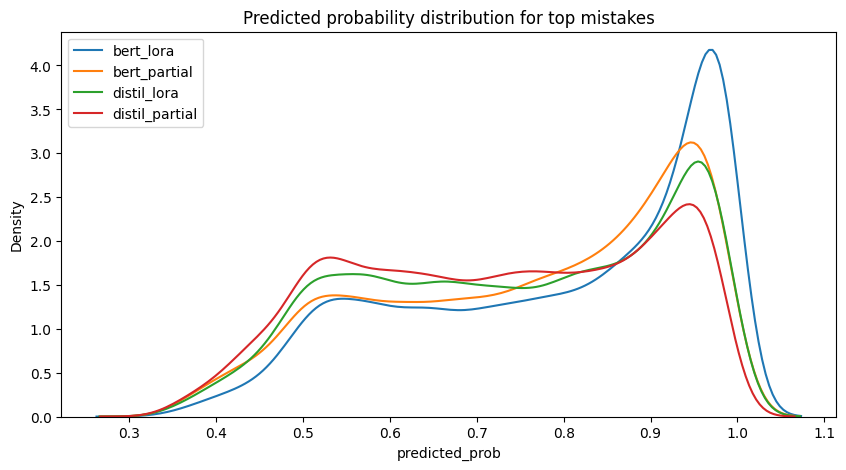

In [33]:
# -------------------------------------------------------------------
# 6) CONFIDENCE DISTRIBUTIONS
# -------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for name, df in models.items():
    sns.kdeplot(df["predicted_prob"], label=name, ax=ax)

ax.set_title("Predicted probability distribution for top mistakes")
ax.legend()
plt.show()

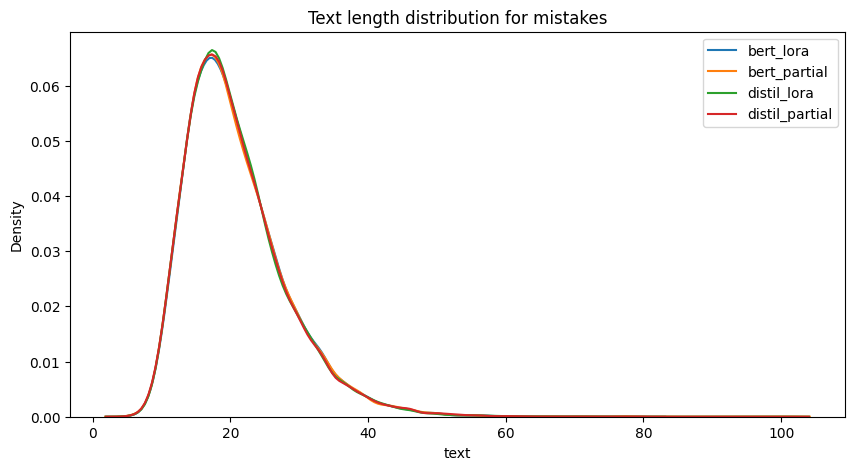

In [34]:
# -------------------------------------------------------------------
# 7) LENGTH ANALYSIS
# -------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for name, df in models.items():
    sns.kdeplot(df["text"].str.split().str.len(), label=name, ax=ax)

ax.set_title("Text length distribution for mistakes")
ax.legend()
plt.show()

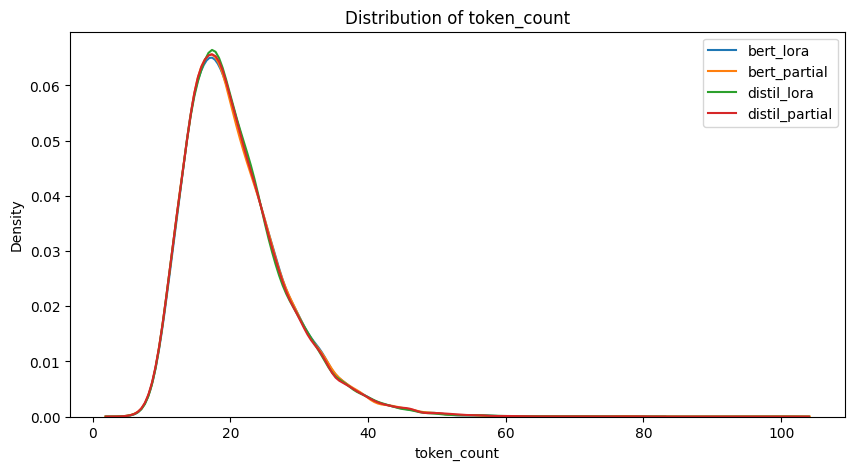

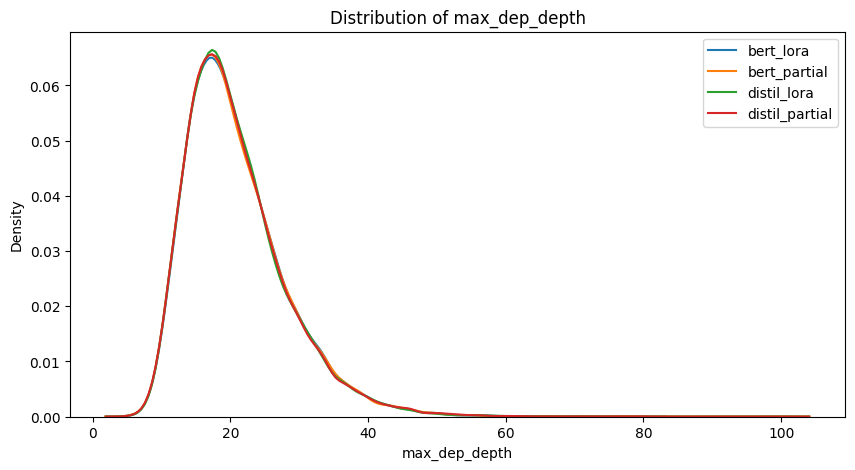

C:\Users\Besitzer\AppData\Local\Temp\ipykernel_23032\363680852.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col], label=name)
C:\Users\Besitzer\AppData\Local\Temp\ipykernel_23032\363680852.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col], label=name)
C:\Users\Besitzer\AppData\Local\Temp\ipykernel_23032\363680852.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col], label=name)
C:\Users\Besitzer\AppData\Local\Temp\ipykernel_23032\363680852.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col], label=name)
C:\Users\Besitzer\AppData\Local\Temp\ipykernel_23032\363680852.py:11: UserWarning: No artists with labels found to put i

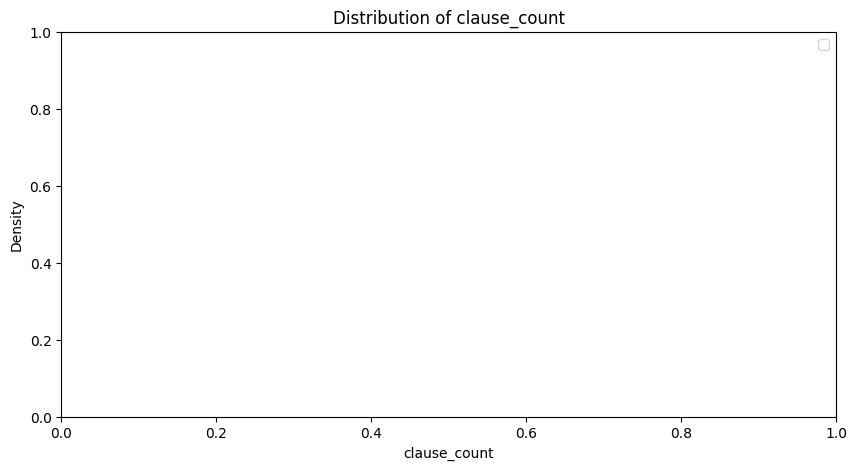

In [35]:
# -------------------------------------------------------------------
# 8) STRUCTURAL FEATURES COMPARISON
# -------------------------------------------------------------------
struct_cols = ["token_count", "max_dep_depth", "clause_count"]
for col in struct_cols:
    plt.figure(figsize=(10, 5))
    for name, df in models.items():
        if col in df.columns:
            sns.kdeplot(df[col], label=name)
    plt.title(f"Distribution of {col}")
    plt.legend()
    plt.show()

In [36]:
def analyze_probabilities(df, model_name="Model"):
    print(f"=== Probability Analysis for {model_name} ===")

    df["diff_prob"] = abs(df["predicted_prob"] - df["true_prob"])

    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # 1: Scatter
    sns.scatterplot(
        data=df,
        x="true_prob",
        y="predicted_prob",
        hue="predicted_label",
        alpha=0.6,
        ax=axes[0]
    )
    axes[0].set_title("True vs Predicted Prob")
    axes[0].grid(alpha=0.3)

    # 2: Predicted KDE
    for label in df['predicted_label'].unique():
        sns.kdeplot(
            df[df['predicted_label'] == label]['predicted_prob'],
            label=label,
            ax=axes[1]
        )
    axes[1].set_title("Predicted Prob Distribution")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # 3: Difference boxplot
    sns.boxplot(
        data=df,
        x="predicted_label",
        y="diff_prob",
        ax=axes[2]
    )
    axes[2].set_title("Predicted − True Probability")
    axes[2].grid(alpha=0.3)

    plt.suptitle(f"{model_name} Probability Analysis", fontsize=16)
    plt.tight_layout()
    plt.show()


=== Probability Analysis for BERT LoRA ===


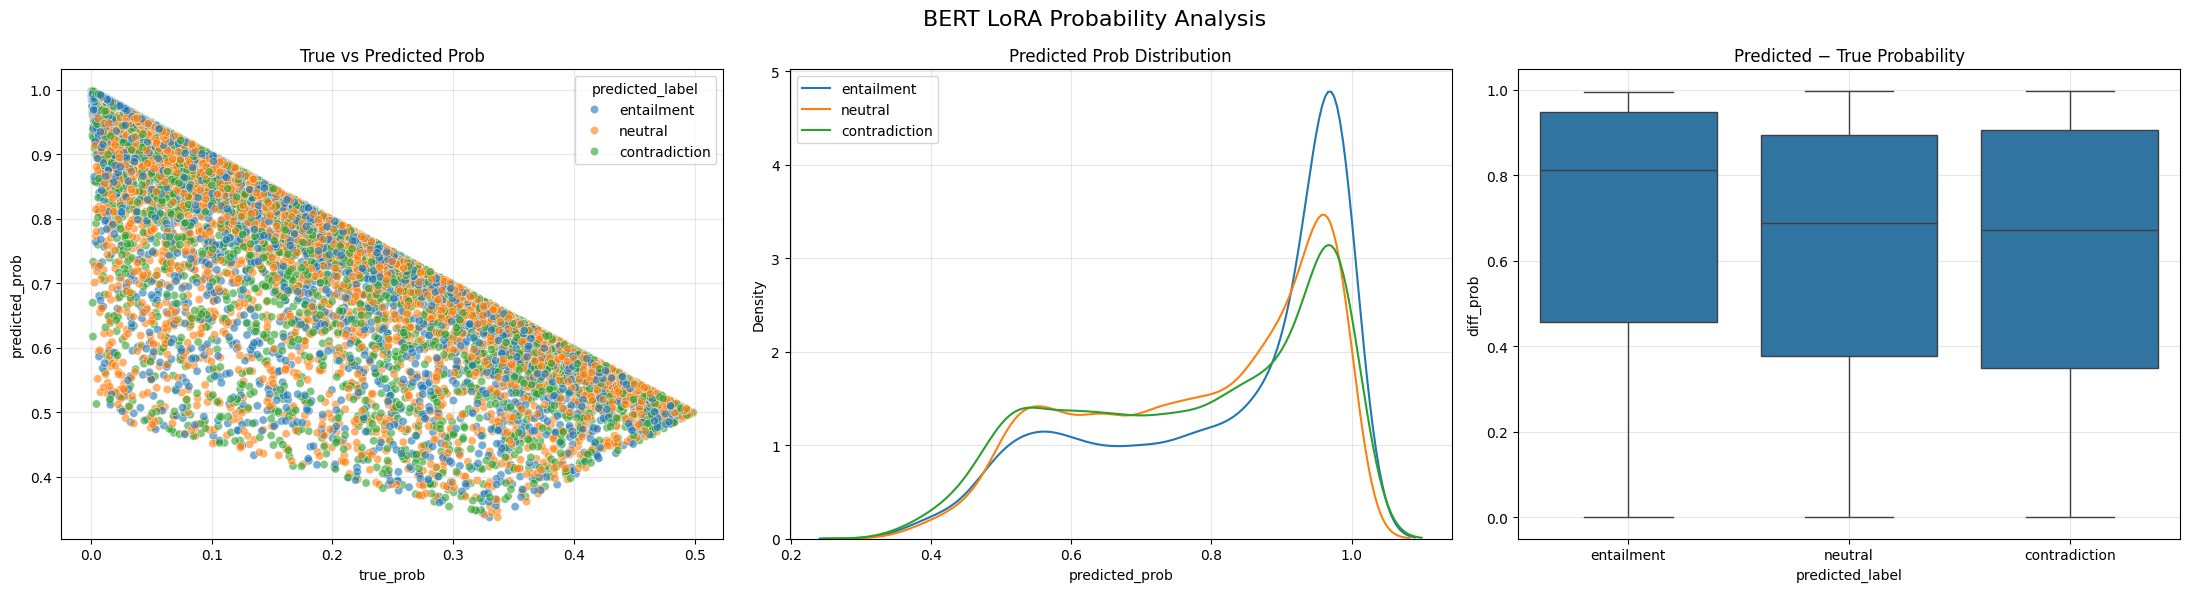

In [37]:
analyze_probabilities(df_bert_lora, "BERT LoRA")

=== Probability Analysis for BERT LoRA Partial Fine-tune ===


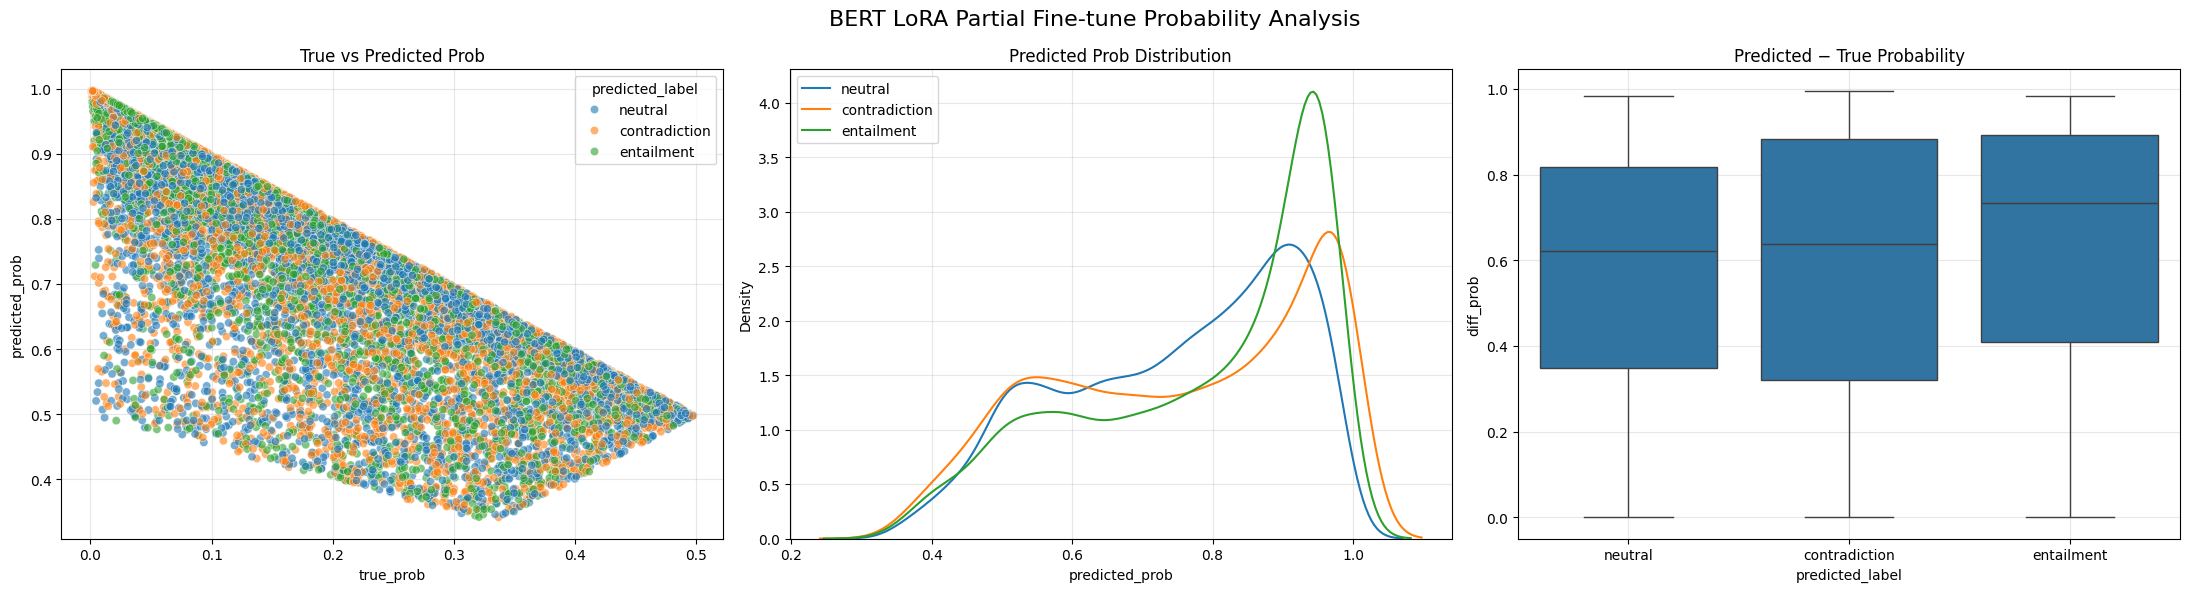

In [38]:
analyze_probabilities(df_bert, "BERT LoRA Partial Fine-tune")

=== Probability Analysis for Destileld BERT LoRA ===


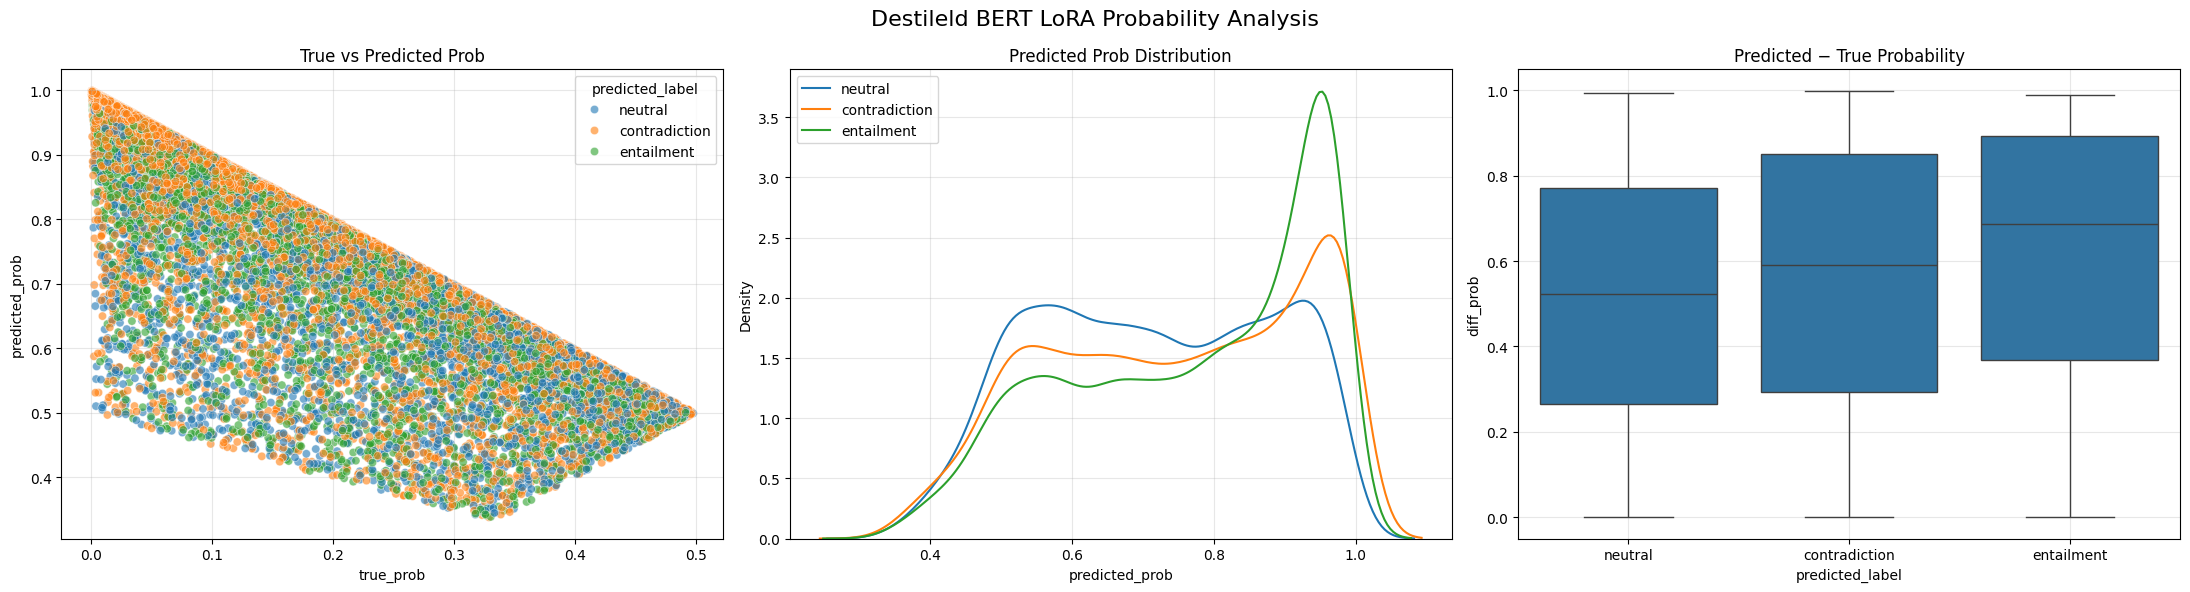

In [39]:
analyze_probabilities(df_distilled_bert_lora, "Destileld BERT LoRA")

=== Probability Analysis for DEstilled BERT Partial ===


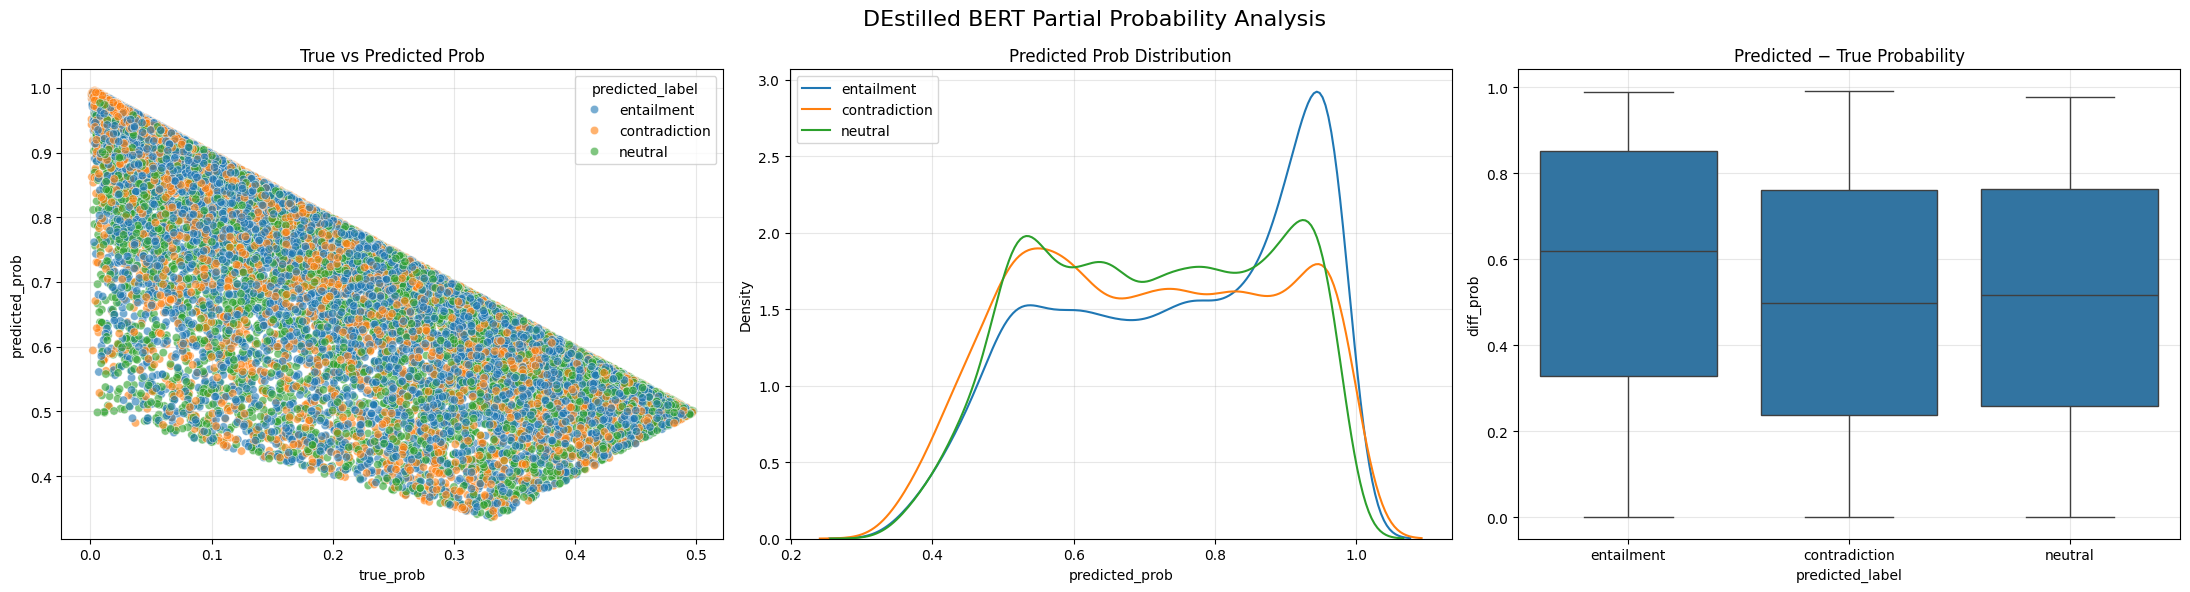

In [40]:
analyze_probabilities(df_distilled_bert, "DEstilled BERT Partial")

# Model Misclassification & Edge Case Analysis Summary

## 1. Overview
This document summarizes the misclassification and edge-case patterns observed across four fine-tuning strategies applied to BERT and DistilBERT:

- **BERT LoRA**
- **BERT Partial Fine‑Tune**
- **DistilBERT LoRA**
- **DistilBERT Partial Fine‑Tune**

The analysis integrates:
- Misclassified sample distributions  
- Probability behavior  
- Structural features (text length, token count)  
- Embedding-based UMAP + HDBSCAN edge-case clustering  
- Keyword drift in top misclassified examples  

---

## 2. Key Findings

### **2.1 All Models Share the Same Weakness: Neutral Class**
Across *all* fine‑tuning strategies, most misclassifications involve the **neutral** class.  
This is consistent in:
- **True label distribution**
- **Predicted label distribution**
- **Probability confusion patterns**
- **Cluster visualizations**

Neutral is the most semantically ambiguous class and the primary source of errors.

---

## 3. Label Distributions in Top Misclassifications

### **3.1 True Labels**
All models show:
- ~40–50% **neutral**
- ~25–30% **contradiction**
- ~20–30% **entailment**

DistilBERT LoRA struggles the most, showing **neutral > 50%** in mistakes.

### **3.2 Predicted Labels**
All models frequently *predict* neutral even when incorrect.

DistilBERT LoRA and DistilBERT partial are especially biased toward neutral.

---

## 4. Probability Behavior

### **4.1 High Confidence Mistakes**
- BERT LoRA: predictions cluster at **0.9–1.0** for many wrong examples.
- BERT partial: also overconfident, slightly less extreme.
- Distil models: confidence is lower but still inflated.

All models produce **overconfident wrong predictions**, especially on neutral → entailment/contradiction.

### **4.2 Probability Gap (Predicted − True Class Prob)**
Across all models:
- Misclassified examples show **large gaps**  
- Neutral mistakes have the *largest probability gaps*  
- DistilBERT LoRA has the **biggest overconfidence spread**

---

## 5. Structural Features

### **5.1 Text Length / Token Count**
All models show the same effect:
- Misclassified texts cluster around **15–25 tokens**
- Longer/shorter texts do **not** increase error rate
- No model shows sensitivity to text length

This indicates that structural complexity is **not** the main driver of mistakes.

---

## 6. Embedding‑based Edge Case Clustering

UMAP + HDBSCAN shows:

### **6.1 BERT LoRA & BERT Partial**
- Produce **cleaner UMAP manifolds**
- More clusters appear as small, meaningful regions
- Noise cluster (-1) is small and localized
- BERT partial fine‑tune clusters are tighter → better geometry

### **6.2 DistilBERT LoRA**
- Large noisy regions
- Fewer stable clusters
- Embedding space is less separable → matches probability confusion

### **6.3 DistilBERT Partial Fine‑Tune**
- Best manifold among Distil models
- Still far noisier than BERT models
- Neutral drift appears as several disconnected mini‑clusters

### **6.4 Common Pattern Across All Models**
- Hard clusters correspond to **visually ambiguous image-caption pairs**
- Neutral/entailment confusion clusters overlap heavily
- A ring-like structure appears across all runs → models encode ambiguity similarly

---

## 7. Keyword Drift in Misclassified Examples

All models show nearly identical top keywords:

```
man, woman, people, wearing, shirt,
young, white, black, girl, dog, playing,
blue, sitting, red, group, street, outside
```

### Interpretation:
- These are **generic words common across all samples**
- They **lack strong entailment/contradiction cues**
- This reinforces: **models struggle with generic, non-informative captions**

LoRA vs full fine‑tune **does NOT change** the lexical profile of mistakes.

---

## 8. Final Conclusions

### **1. All models fail for the same reason → Neutral confusion**
Fine‑tuning method does not fix this fundamental issue.

### **2. BERT models (LoRA + Partial) produce better embedding manifolds**
Cleaner cluster structure → better semantic discrimination.

### **3. DistilBERT is systematically worse**
LoRA particularly destabilizes the embedding space.

### **4. Overconfidence is universal**
All models make **high-confidence mistakes**.

### **5. The real issue is dataset-level ambiguity**
Most difficult samples are inherently ambiguous:
- Generic descriptions  
- Missing relational cues  
- Low-information tokens  

### **6. Fine‑tuning method does not meaningfully change the *types* of mistakes**
It changes **how many** errors occur, not **which** ones occur.

---


In [41]:
from sklearn.metrics import confusion_matrix

def plot_misclassification_confusion(df, title):
    cm = confusion_matrix(df["true_label"], df["predicted_label"], labels=["entailment","neutral","contradiction"])
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["entailment","neutral","contradiction"],
                yticklabels=["entailment","neutral","contradiction"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

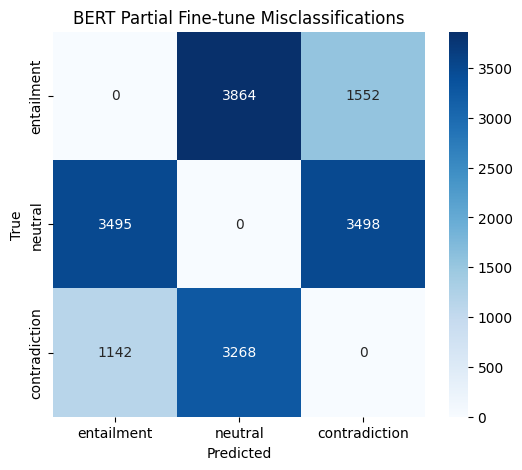

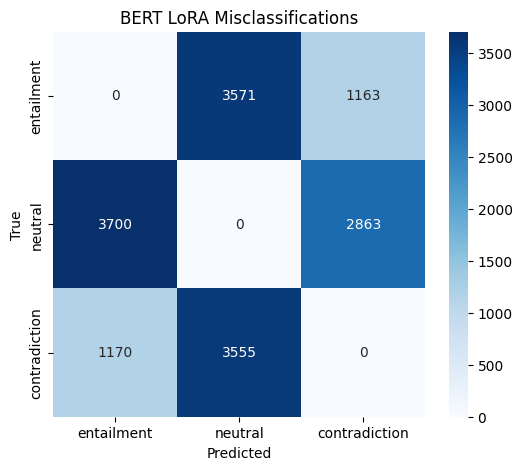

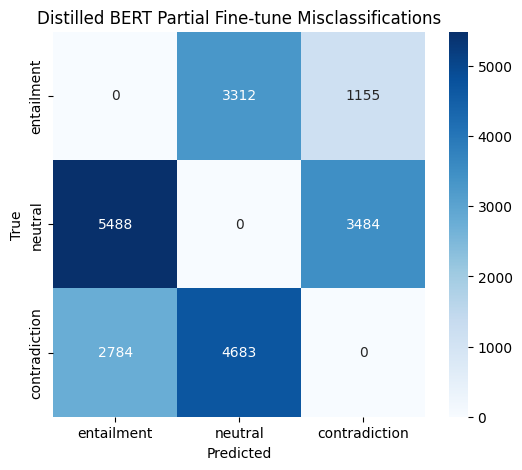

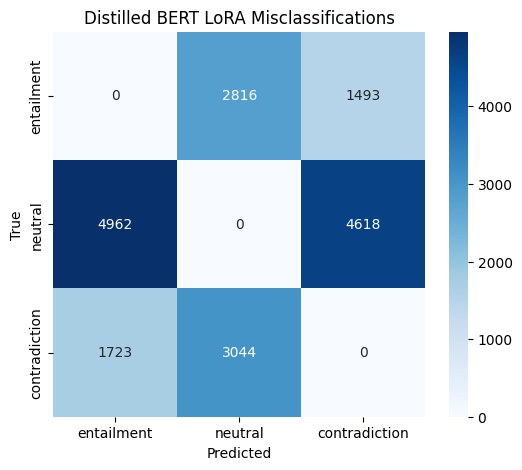

In [43]:
plot_misclassification_confusion(df_bert, "BERT Partial Fine-tune Misclassifications")
plot_misclassification_confusion(df_bert_lora, "BERT LoRA Misclassifications")
plot_misclassification_confusion(df_distilled_bert, "Distilled BERT Partial Fine-tune Misclassifications")
plot_misclassification_confusion(df_distilled_bert_lora, "Distilled BERT LoRA Misclassifications")

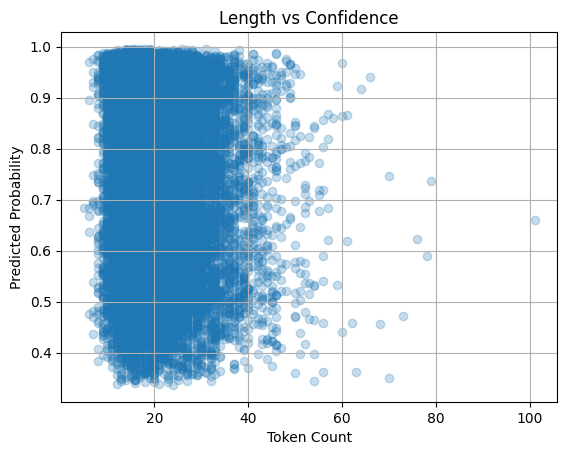

In [55]:
plt.scatter(df["token_count"], df["predicted_prob"], alpha=0.25)
plt.xlabel("Token Count")
plt.ylabel("Predicted Probability")
plt.title("Length vs Confidence")
plt.grid(True)
plt.show()